# Perform time series analysis and prediction using ARIMA

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from joblib import dump
from joblib import load

In [2]:
df = pd.read_csv("data/Mastercard_stock_history.csv")
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2006-05-25,3.748967,4.283869,3.739664,4.279217,395343000,0.0,0.0
1,2006-05-26,4.307126,4.348058,4.103398,4.179680,103044000,0.0,0.0
2,2006-05-30,4.183400,4.184330,3.986184,4.093164,49898000,0.0,0.0
3,2006-05-31,4.125723,4.219679,4.125723,4.180608,30002000,0.0,0.0
4,2006-06-01,4.179678,4.474572,4.176887,4.419686,62344000,0.0,0.0


## Exploratory data analysis

Maybe we can implement an ARIMAX model, to predict close price, using features such as:

1. Lagged days opening prices
2. Previous days' open, volume
3. Moving average standard deviations and mean prices

We will fit a model to this to see if it works

In [3]:
# convert Date into datetime, and set the date as the index of the dataframe
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df.asfreq("D")
df.dtypes

Open            float64
High            float64
Low             float64
Close           float64
Volume          float64
Dividends       float64
Stock Splits    float64
dtype: object

In [4]:
df = df.interpolate()
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5619 entries, 2006-05-25 to 2021-10-11
Freq: D
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          5619 non-null   float64
 1   High          5619 non-null   float64
 2   Low           5619 non-null   float64
 3   Close         5619 non-null   float64
 4   Volume        5619 non-null   float64
 5   Dividends     5619 non-null   float64
 6   Stock Splits  5619 non-null   float64
dtypes: float64(7)
memory usage: 351.2 KB


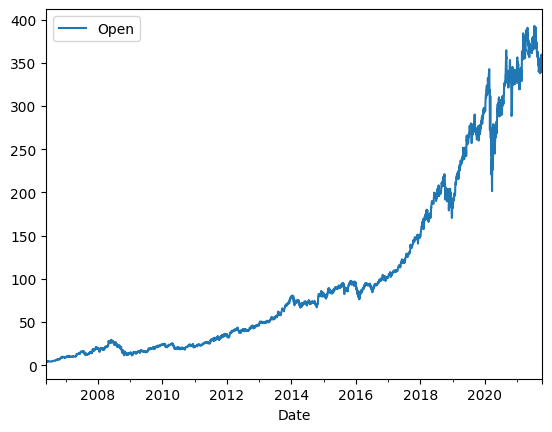

In [5]:
# plot the time series of Mastercard over the years
df.plot(y = "Open")
plt.show()

We can see that the time series is definitely not stationary.

This is because we can see that mean opening price increases over time. Furthermore, the variance of the time series seems to have increased after 2018

<Axes: xlabel='Date'>

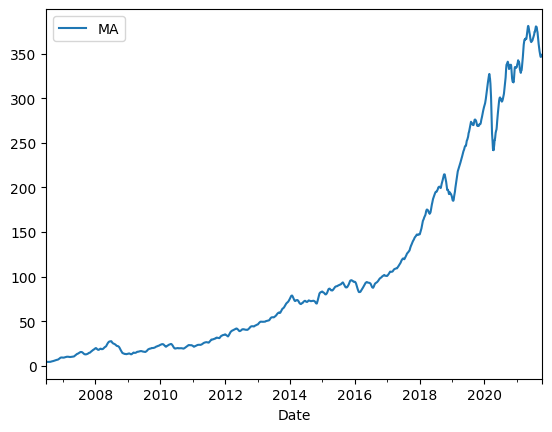

In [6]:
# plot the lag-1 rolling 30 day average of the time series
df["MA"] = df["Close"].shift(1).rolling(30).mean()
df = df.dropna()

df.plot(y = 'MA')

The trend is more smoothed, but we can still see a lot of variation

C:\Users\yjiah\AppData\Local\Temp\ipykernel_17392\3830149131.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["STD_MA"] = df["Close"].shift(1).rolling(30).std()


<Axes: xlabel='Date'>

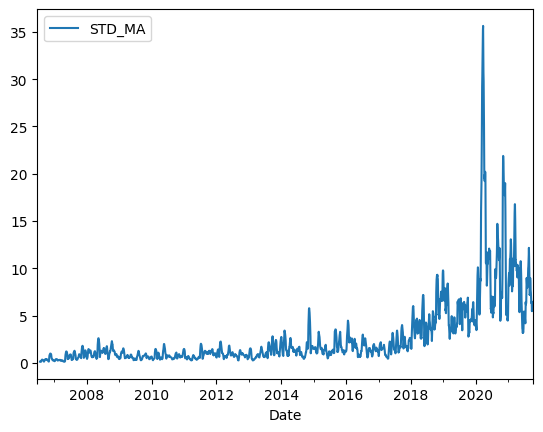

In [7]:
# plot the lag-1 30 day rolling standard deviation of the time series
df["STD_MA"] = df["Close"].shift(1).rolling(30).std()
df.plot(y = "STD_MA")

Variance of the time series spiked around 2020

## Check for stationarity of time series

In [8]:
# we will use the adfuller test
# null hypothesis: time series is not stationary
# alternative hypothesis: time series is stationary

results = adfuller(df["Close"])
print(f"Test statistic: {results[0]}")
print(f"p-value: {results[1]}")

Test statistic: 1.2480824050901858
p-value: 0.9963018191941321


Since the p-value is very close to 1, we cannot reject the null hypothesis that the time series is not stationary

## Make time series stationary

C:\Users\yjiah\AppData\Local\Temp\ipykernel_17392\2309125593.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["log_close"] = np.log(df["Close"])
C:\Users\yjiah\AppData\Local\Temp\ipykernel_17392\2309125593.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["log_close_diff"] = np.log(df["Close"]).diff()


<Axes: xlabel='Date'>

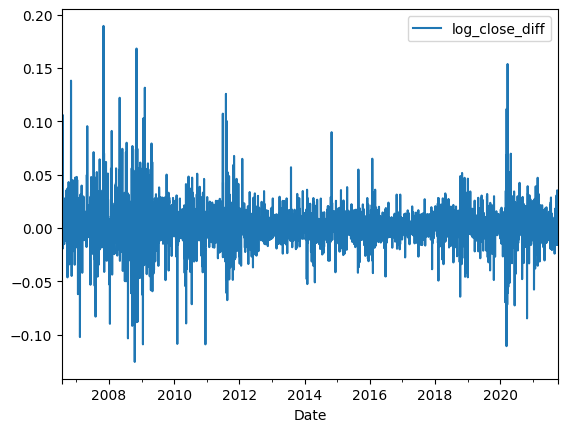

In [9]:
# apply log-transform so that variance is constant over time
df["log_close"] = np.log(df["Close"])
df["log_close_diff"] = np.log(df["Close"]).diff()
df = df.dropna()
df.plot(y = "log_close_diff")

Now the time series is definitely stationary. We can predict on this transformed time series, then perform integration of time series and the reverse of log-transform to get back to our actual predicted values

In [10]:
# we will use the adfuller test
# null hypothesis: time series is not stationary
# alternative hypothesis: time series is stationary

results = adfuller(df["log_close_diff"])
print(f"Test statistic: {results[0]}")
print(f"p-value: {results[1]}")

Test statistic: -25.134809772738134
p-value: 0.0


After first-order differencing, the p-value for the Augmented Dickey-Fuller Test is now extremely small. We can reject the null hypothesis (time series is not stationary) at level 0.001.

As such, we will use d = 1 in our ARIMAX model on the `log_close` column

## ACF and PACF plots

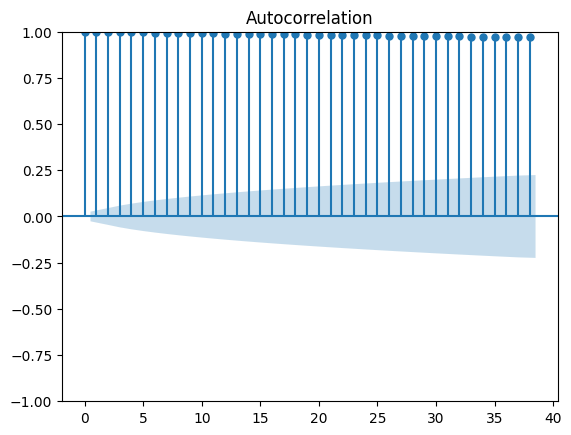

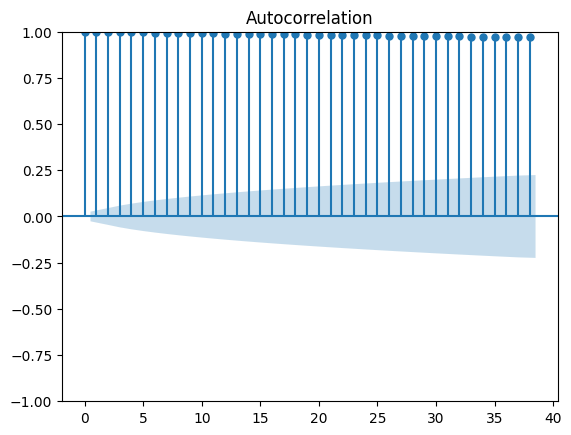

In [11]:
plot_acf(df['log_close'])

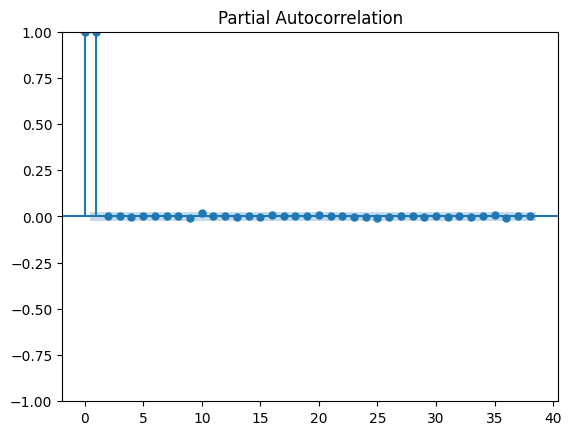

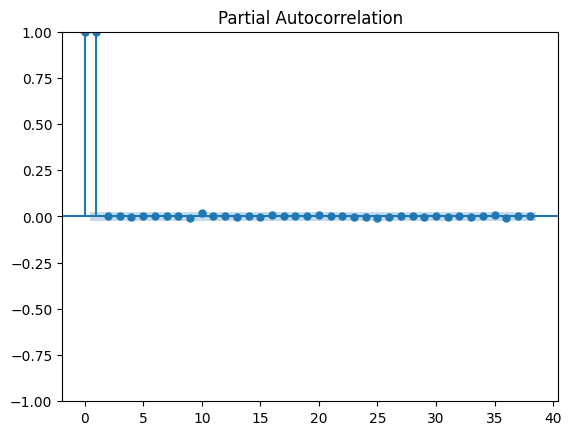

In [12]:
plot_pacf(df['log_close'])

The ACF plot tails off, while the PACF plot cuts off after p = 2. This suggests p = 2 for our ARIMA(p, d, q) model, and q = 0

## Standardize other variables we want to use in modelling

In [13]:
scaler = StandardScaler()
# the below are also regressors we will use to predict the price of the stock (log_close)
cols_to_standardize = ["Open", "Volume", "MA", "STD_MA"]
df[cols_to_standardize] = scaler.fit_transform(df[cols_to_standardize])

## Fitting the ARIMAX model

In [14]:
cols_to_keep = ["Open", "Volume", "MA", "STD_MA", "log_close", "Close"]
df1 = df[cols_to_keep]

In [15]:
# fit on all data except last 20 days

model = ARIMA(
    endog = df1['log_close'][:-20],
    exog = df1[["Open", "Volume", "MA", "STD_MA"]][:-20],
    order = (2, 1, 0)
)

result = model.fit()

c:\Users\yjiah\Downloads\time-series-stocks\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [16]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              log_close   No. Observations:                 5539
Model:                 ARIMA(2, 1, 0)   Log Likelihood               14954.099
Date:                Sun, 08 Dec 2024   AIC                         -29894.198
Time:                        22:30:15   BIC                         -29847.863
Sample:                    07-24-2006   HQIC                        -29878.042
                         - 09-21-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Open           0.1744      0.006     29.651      0.000       0.163       0.186
Volume         0.0018   7.19e-05     25.494      0.000       0.002       0.002
MA            -0.1777      0.035     -5.123      0.000      -0.246      -0.110
STD_MA        -0.0032      0.003     -1.236      0.216      -0.008       0.002
ar.L1         -0.0531      0.008     -6.658      0.000      -0.069      -0.037
ar.L2         -0.0115      0.009     -1.348      0.178      -0.028       0.005
sigma2         0.0003    1.8e-06    146.728      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):             47407.07
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               0.34   Skew:                             0.29
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [17]:
# create one-step ahead predictions

forecast = result.get_prediction(start = df1.index[-20], end = df1.index[-1], exog = df1[["Open", "Volume", "MA", "STD_MA"]][-20:])
mean_forecast = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

In [18]:
mean_forecast.values

array([5.81719297, 5.82941966, 5.84367325, 5.84546631, 5.84667002,
       5.8481974 , 5.84536216, 5.84112931, 5.84446427, 5.83643353,
       5.84107484, 5.8459149 , 5.85115658, 5.83042965, 5.81791622,
       5.83308758, 5.84389526, 5.84245587, 5.84125286, 5.83999533])

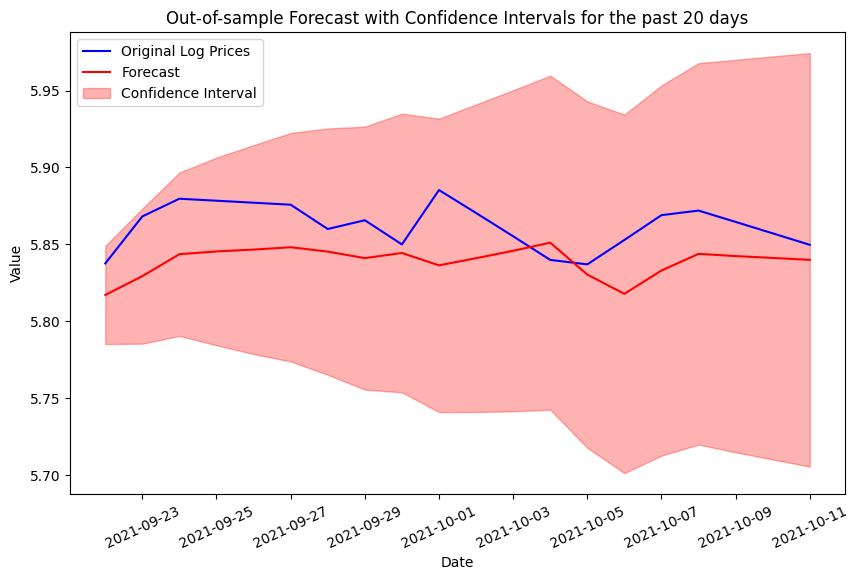

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(df1.index[-20:], df1['log_close'][-20:], label = "Original Log Prices", color = "blue")
plt.plot(mean_forecast.index, mean_forecast.values, label = "Forecast", color = "red")

plt.fill_between(
    mean_forecast.index,
    confidence_intervals.iloc[:, 0],
    confidence_intervals.iloc[:, 1],
    color = "red",
    alpha = 0.3,
    label = "Confidence Interval"
)

# Add labels and title
plt.title("Out-of-sample Forecast with Confidence Intervals for the past 20 days")
plt.xlabel("Date")
plt.ylabel("Value")
plt.xticks(rotation = 25)
plt.legend()

# Show the plot
plt.show()

We can see that our confidence intervals for prediction expectedly increases as our time horizon increases

In [20]:
# calculate the MSE of our predictions against the actual log values
mse = mean_squared_error(df1['log_close'][-20:], mean_forecast.values)
print(f"MSE of our model: {mse}")
print(f"AIC of our model: {result.aic}")

MSE of our model: 0.0007258607748721907
AIC of our model: -29894.198251572707


## Plot our predictions against the actual prices

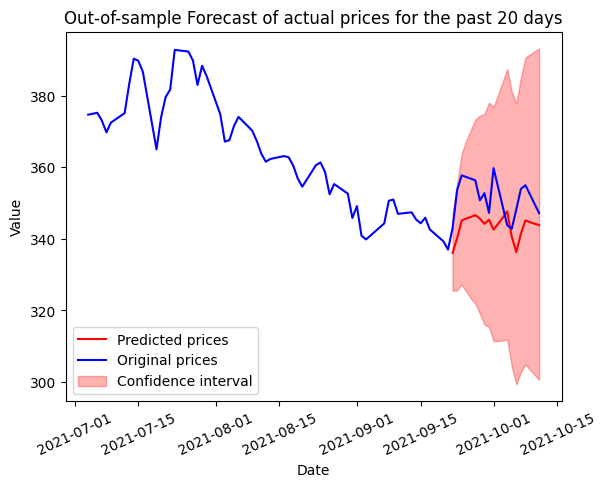

In [21]:
predicted_prices = np.exp(mean_forecast)
conf_int = np.exp(confidence_intervals)

plt.plot(predicted_prices, color = "red", label = "Predicted prices")
plt.plot(df1['Close'][-100:], label = "Original prices", color = "blue")

plt.fill_between(
    mean_forecast.index,
    conf_int.iloc[:, 0],
    conf_int.iloc[:, 1],
    color = "red",
    alpha = 0.3,
    label = "Confidence interval"
)

# Add labels and title
plt.title("Out-of-sample Forecast of actual prices for the past 20 days")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.xticks(rotation = 25)

# Show the plot
plt.show()

plt.show()

In [22]:
mse = mean_squared_error(df1['Close'][-20:], np.exp(mean_forecast.values))
print(f"Root mean-squared error of our predictions: {np.sqrt(mse): .2f}")

Root mean-squared error of our predictions:  9.40


## Save the trained model

In [23]:
dump(result, "./models/arimax_model.pkl")

['./models/arimax_model.pkl']

In [24]:
# test loading of model
loaded_model = load("./models/arimax_model.pkl")
forecast = loaded_model.get_prediction(start = df1.index[-20], end = df1.index[-1], exog = df1[["Open", "Volume", "MA", "STD_MA"]][-20:])
mean_forecast = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

In [25]:
mean_forecast.values

array([5.81719297, 5.82941966, 5.84367325, 5.84546631, 5.84667002,
       5.8481974 , 5.84536216, 5.84112931, 5.84446427, 5.83643353,
       5.84107484, 5.8459149 , 5.85115658, 5.83042965, 5.81791622,
       5.83308758, 5.84389526, 5.84245587, 5.84125286, 5.83999533])

It gives the same forecast values, so our model is successfully saved and loaded